In [40]:
import pandas as pd
import nltk
#import stanza -> pytorch

In [41]:
df_fake_id = pd.read_csv("final_fake.csv", sep='\t')
df_fake_id.rename(columns={'FakeID':'FakeID',
                          'text':'corpus'}, 
                 inplace = True)
#df_fake_id.head()
#len(df_fake_id)

In [43]:
sentenses_list = df_fake_id['corpus'].tolist()

In [44]:
#preprocessing
dropped_nan_sentenses_list = [x for x in sentenses_list if str(x) != 'nan']

lowered_sentenses_list = dropped_nan_sentenses_list
for i in range(len(dropped_nan_sentenses_list)):
    lowered_sentenses_list[i] = dropped_nan_sentenses_list[i].lower()
#func strip/translate - 30 minutes spent

In [61]:
#lowered_sentenses_list

In [8]:
import json

def text2json(sentences):
    sentences_dict = []
    for s in sentences:
        sentences_dict.append({'text': s})
    with open('texts.json', 'w') as outfile:
        json.dump(sentences_dict, outfile)

In [45]:
text2json(lowered_sentenses_list)

# doc2vec

In [63]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [64]:
#nltk.download('punkt')

In [65]:
documents = [TaggedDocument(doc, [i]) for i, 
             doc in enumerate(lowered_sentenses_list)]

model_d2v = Doc2Vec(documents, 
                vector_size = 100, 
                window = 2, 
                min_count = 3, 
                workers = 4)

In [166]:
documents

[TaggedDocument(words="i've been on and off depression for my entire life, sometimes it can be triggered by a traumatic event, but in most cases it just happens.i have friends, i have a good job, i have a roof over my head, and i have hobbies that make me happy.i have friends, i have a good job, i have a roof over my head, and i have hobbies that make me happy.i have friends, i have a good job, i have a roof over my head, and i have hobbies that make me happy.i have friends, i have a good job, i have a roof over my head, and i have hobbies that make me happy.however, i still go through episodes of just feeling completely alone, sad, and suicidal. i'm at the point where i've just accepted it and try to roll with it until it goes away for a few days and i can feel somewhat normal.but unfortunately, none of my family or friends can really understand it. they get angry at me for being depressed or spending days locked in my room. i tell them that i can't control it, but they always say i'm

## Model training (5 minutes)

In [66]:
model_d2v.train(documents, 
                total_examples = model_d2v.corpus_count, 
                epochs = 50, 
                start_alpha = 0.002, 
                end_alpha = -0.016)

# Elbow method

In [67]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

In [75]:
#kmeans

[KMeans(max_iter=200, n_clusters=1, n_init=100),
 KMeans(max_iter=200, n_clusters=2, n_init=100),
 KMeans(max_iter=200, n_clusters=3, n_init=100),
 KMeans(max_iter=200, n_clusters=4, n_init=100),
 KMeans(max_iter=200, n_clusters=5, n_init=100),
 KMeans(max_iter=200, n_clusters=6, n_init=100),
 KMeans(max_iter=200, n_clusters=7, n_init=100),
 KMeans(max_iter=200, n_init=100),
 KMeans(max_iter=200, n_clusters=9, n_init=100),
 KMeans(max_iter=200, n_clusters=10, n_init=100),
 KMeans(max_iter=200, n_clusters=11, n_init=100),
 KMeans(max_iter=200, n_clusters=12, n_init=100),
 KMeans(max_iter=200, n_clusters=13, n_init=100),
 KMeans(max_iter=200, n_clusters=14, n_init=100),
 KMeans(max_iter=200, n_clusters=15, n_init=100),
 KMeans(max_iter=200, n_clusters=16, n_init=100),
 KMeans(max_iter=200, n_clusters=17, n_init=100),
 KMeans(max_iter=200, n_clusters=18, n_init=100),
 KMeans(max_iter=200, n_clusters=19, n_init=100)]

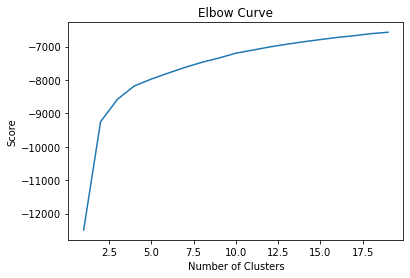

In [69]:
nc = range(1,20)
kmeans = []
score = []
kmeans = [KMeans(n_clusters = i, n_init = 100, max_iter = 200) for i in nc]
#n_init - 
#max_iter - 
score = [kmeans[i].fit(model_d2v.docvecs.vectors_docs).score(model_d2v.docvecs.vectors_docs) for i in range(len(kmeans))]

# Plot the elbow
plt.plot(nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

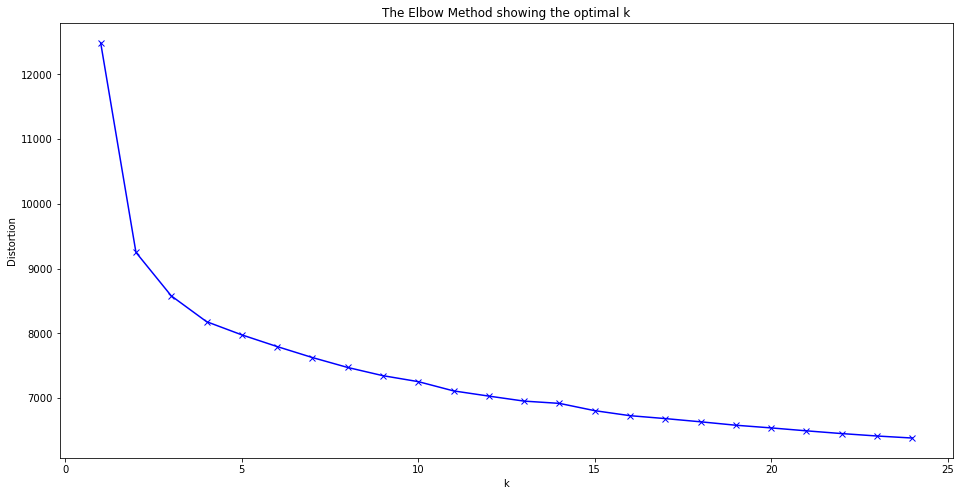

In [74]:
distortions = []
K = range(1,25)
for k in K:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(model_d2v.docvecs.vectors_docs)
    distortions.append(kmeanModel.inertia_) 
    #Sum of squared distances of samples to their closest cluster center.

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion') #sum of squared distances from each point to its assigned center
plt.title('The Elbow Method showing the optimal k')
plt.show()

## doc2vec clustering

In [78]:
K_value = 9
kmeans_model = KMeans(n_clusters = K_value, init = 'k-means++')  
X = kmeans_model.fit(model_d2v.docvecs.vectors_docs)
labels = kmeans_model.labels_.tolist()
clusters = kmeans_model.fit_predict(model_d2v.docvecs.vectors_docs)

In [80]:
#l = kmeans_model.fit_predict(model_d2v.docvecs.vectors_docs)
from sklearn.decomposition import PCA
pca = PCA(n_components = 2).fit(model_d2v.docvecs.vectors_docs)
datapoint = pca.transform(model_d2v.docvecs.vectors_docs)

## Plot the clustering result

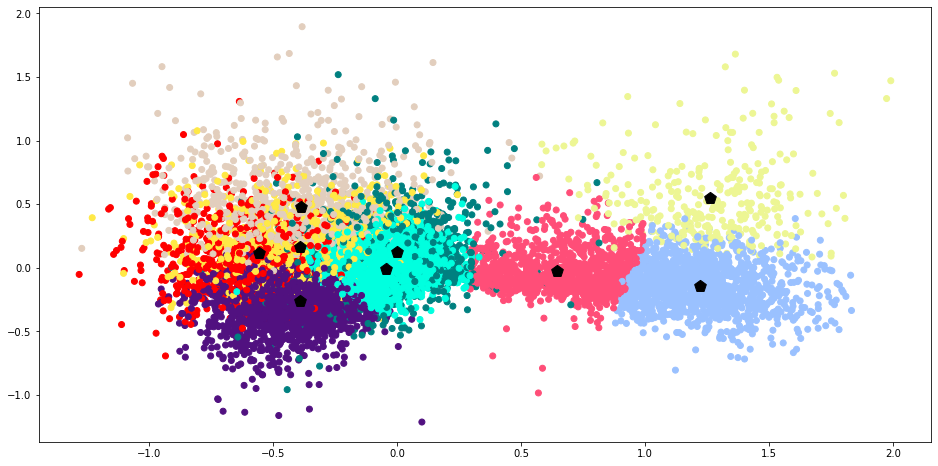

In [141]:
plt.figure(figsize=(16,8))
label1 = ["#FF0000", #deep red
          "#00FFDF", #bright blue-green
          "#9ac1ff", #blue
          "#e2cebd", #light brown
          "#edf694", #yellow
          "#ff4e78", #red-pink
          "#511180", #dark purple
          "#ffe946", #bright yellow
          "#008080"] #dark green
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c = color)

centroids = kmeans_model.cluster_centers_ #get centroids coordinates
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='p', s=150, c='#000000')
plt.show()

In [150]:
df = pd.DataFrame(
    {'doc': lowered_sentenses_list,
     'cluster': labels
    })

In [160]:
df['cluster'].value_counts().sort_index()

0    1001
1    5885
2    1283
3     843
4     300
5    1097
6    2713
7    1109
8     911
Name: cluster, dtype: int64

In [165]:
print(df['doc'][(df["cluster"] == 1)][:50])

0      i've been on and off depression for my entire ...
3      i just want to be myself again.i am full of an...
7      2017 started it jobless. struggling with every...
39     alone at new year's eve. i remembered that my ...
73     severely depressed and isolated. wondering whe...
93     my depression around the holidays usually sky ...
107    they say i have low self-esteem. i say: i have...
112    perhaps i'm feeling maudlin because it's new y...
136    i'm a 20 year-old female. i've been having dep...
152    i actually feel the same.this year was a shit,...
153    this past month has hit me like a freight trai...
162    on the last day of 2017 i've decided that 2018...
193    depression functions in a way where our percie...
240    it's totally arbitrary, and that really isn't ...
245    i have a long story but don't feel like giving...
248    i have improved my life significantly over the...
252    4 am, can't sleep, as always. i really need to...
253    it seems petty that i ha

In [140]:
cluster_texts = {}
for k in range(9):
    cluster_texts[k] = []
text_count = 0

for sent in lowered_sentenses_list:
    Y = vectorizer.transform([sent])
    prediction = model_d2v.fit_predict(Y)
    cluster_texts[prediction[0]].append(lowered_sentenses_list[text_count])
    text_count+=1

AttributeError: 'Doc2Vec' object has no attribute 'fit_predict'

Resourses used:
https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4
https://predictivehacks.com/k-means-elbow-method-code-for-python/
https://github.com/aniketbote/Document-Clustering-Doc2vec/blob/master/Clustering/Clustering_code_Doc2Vec/clustering_Documents_Doc2Vec.py


# TF-IDF

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(lowered_sentenses_list)

# word2vec

In [23]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [24]:
new_vec = [nltk.word_tokenize(blog_post) for blog_post in lowered_sentenses_list]

In [33]:
model_1 = Word2Vec(new_vec, min_count = 5, size = 50)

In [34]:
model_1.wv.most_similar('pain', topn = 5)

[('sadness', 0.8105345964431763),
 ('despair', 0.7589633464813232),
 ('guilt', 0.7365403771400452),
 ('loneliness', 0.7183157205581665),
 ('misery', 0.7154360413551331)]

In [30]:
#text 
tokenizer = nltk.tokenize.TreebankWordTokenizer()

tok_lowered_sentenses_list = dropped_nan_sentenses_list
for i in range(len(lowered_sentenses_list)):
    tok_lowered_sentenses_list[i] = tokenizer.tokenize(lowered_sentenses_list[i])

model_2 = Word2Vec(tok_lowered_sentenses_list, size = 100, 
                   window = 5, min_count = 5, workers = 3)
#model_2.wv.vocab
#size: The number of dimensions of the embeddings and the default is 100.
#window: The maximum distance between a target word and words around the target word. The default window is 5.
#min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
#workers: The number of partitions during training and the default workers is 3.
#sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

In [32]:
model_2.wv.most_similar('pain', topn = 5)

[('pain.', 0.755516529083252),
 ('sadness', 0.7153457403182983),
 ('existence', 0.6558433771133423),
 ('guilt', 0.6493241786956787),
 ('loneliness', 0.6416699886322021)]

1. How can I define which one is better? or is it necessary to look into the final result rather then into comparisson of the tokenizer and word to vec?
2. TASK: read & select necessary params for Word2Vec: https://radimrehurek.com/gensim/models/word2vec.html
3. CBOW vs. Skip-gram - just experiment! + learn more

1. Resources used:
https://www.youtube.com/watch?v=UqRCEmrv1gQ
https://www.youtube.com/watch?v=MvG4dPplrRo


## useful clustering functions

In [37]:
prediction_list = []
for sent in lowered_sentenses_list:
    Y = vectorizer.transform([sent])
    prediction = model.predict(Y)
    prediction_list.append(prediction[0])
cluster_text_count = []
for k in range(K):
    cluster_text_count.append(prediction_list.count(k))
print (cluster_text_count)

[145, 671, 244, 568, 842, 2963, 2519, 3351, 1242, 528, 2069]


In [38]:
cluster_texts = {}
for k in range(K):
    cluster_texts[k] = []
text_count = 0
for sent in lowered_sentenses_list:
    Y = vectorizer.transform([sent])
    prediction = model.predict(Y)
    cluster_texts[prediction[0]].append(lowered_sentenses_list[text_count])
    text_count+=1

In [55]:
cluster_texts[2]

['i\'m not really expecting sympathy as i know what i did was wrong.  note, this is going to be long lol.so basically i\'ve been seeing this guy online for three months now and we instantly hit it off.  we were texting each other constantly everyday but little did he know that i was actually a catfish who posed as a pretty cute person who was just camera shy.  this was my first time catfishing and instantly after a day of doing it i deleted my account from the dating site but kept in contact with him without telling him who i was.  now, this "relationship" lasted through november and december which were both of our exam months which gave me the perfect excuse to why i couldn\'t meet him since we both live in the same area.  he was the perfect guy to me, we shared stories, our feelings, and talked about what we did on that day.  he was everything that i wanted to be; he was sporty, popular, and talented.  what made me fall for him though was that he was so supportive during my exams wer